In [1]:
#import sys
#sys.path.insert(0, '../../..')
#from Practice.Utils.metrics import evaluate_classification
#from Practice.Utils.plots import plot_decision_boundary, plot_data
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math

In [21]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             r2_score)


def evaluate_regression(y_true, y_pred, use_log = False):
    """Evaluate regression model performance.

    Args:
        y_true (array): Ground truth values.
        y_pred (array): Predicted values.

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    metrics = {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred, squared=False),
        'r2': r2_score(y_true, y_pred)
    }
    if use_log:
        metrics['msle'] = mean_squared_log_error(y_true, y_pred)
    return metrics

def evaluate_classification(y_true, y_pred, labels = None):
    """
    Evaluate classification model performance.

    Args:
        y_true (array): Ground truth values.
        y_pred (array): Predicted values.
        labels (list): List of labels to index the matrix.

    Returns:
        accuracy (float): Accuracy score.
        report (pd.DataFrame): Classification report.
        confusion_matrix (pd.DataFrame): Confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_true, y_pred), labels, labels)
    return accuracy, report, confusion


import matplotlib.colors as mcolors
import torch



def plot_data(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)


def plot_decision_boundary(model, X, y):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0]) + 0.25, 50)
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1]) + 0.25, 50)
    xx, yy = np.meshgrid(x_span, y_span)
    xx_, yy_ = xx.ravel(), yy.ravel()
    grid = np.c_[xx_, yy_]
    if hasattr(model, "predict_proba"):
        pred_func = model.predict_proba(grid)[:,0]
    else:
        # check if torch model
        if hasattr(model, "forward"):
            pred_func = 1 - model(torch.tensor(grid, dtype=torch.double)).detach().numpy()
        else:
            pred_func = 1 - model(grid).numpy()
    z = pred_func.reshape(xx.shape)
    c = plt.contourf(xx, yy, z, cmap="RdYlGn")
    plt.colorbar(c)
    colors = list(mcolors.TABLEAU_COLORS.keys())
    color_values = [colors[int(label)] for label in y]
    plt.scatter(X[:, 0], X[:, 1], marker="x", c=color_values)

In [47]:
class NeuralNet:
    def __init__(self, layer_dims, layer_activations, mini_batch_size = 1, keep_prob=1, patience = 100, normalize = True, learning_rate = 0.01, num_epochs = 30000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.normalize = normalize
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.keep_prob = keep_prob
        self.mini_batch_size = mini_batch_size

        self.best_loss = np.inf
        self.patience = patience
        self.epochs_without_improvement = 0

        self.is_cost_binary: bool
        if layer_activations[-1] == 'sigmoid':
            self.is_cost_binary = True
        else:
            self.is_cost_binary = False
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    '''
    def __softmax(self, Z):
        Z -= np.max(Z, axis=1, keepdims=True)

        exp_z = np.exp(Z)
        A = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        cache = Z

        return A, cache
    '''
    def __softmax(self, Z):
        cache = Z
        A = np.exp(Z)/np.sum(np.exp(Z))
        return A, cache

    def __tanh(self, Z):
        A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
        cache = Z

        return A, cache

    def __relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z

        assert(A.shape == Z.shape)

        return A, cache

    def __sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        cache = Z

        return A, cache
    
    def __linear_forward(self, A, W, b):
        Z = np.matmul(W, A) + b
        cache = (A, W, b)

        assert(Z.shape == (W.shape[0], A.shape[1]))

        return Z, cache

    def __initialize_parameters(self, layer_dims):
        np.random.seed(42)
        self.parameters={}
        self.grads={}

        L = len(layer_dims)
        for l in range(1, L):
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

            assert(self.parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_dims[l], 1))
       
    def __linear_activation_forward(self, A_prev, W, b, activation, keep_prob=1):
        Z, linear_cache = self.__linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A, activation_cache = self.__sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = self.__relu(Z)
        elif activation == "tanh":
            A, activation_cache = self.__tanh(Z)
        elif activation == "softmax":
            A, activation_cache = self.__softmax(Z)

        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob

        cache = (linear_cache, activation_cache, D)

        assert (A.shape == (W.shape[0], A_prev.shape[1]))

        return A, cache
       
    def __forward_propagation(self, X, parameters=None, keep_prob=1):
        caches = []
        A = X
        L = len(parameters) // 2

        for l in range(1, L):
            A_prev = A
            A, cache = self.__linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = self.layer_activations[l - 1], keep_prob=keep_prob)
            caches.append(cache)
        
        AL, cache = self.__linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = self.layer_activations[L - 1])
        caches.append(cache)


        return AL, caches
    
    def compute_cost_binary(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def compute_cost_multi_class(self, A, Y):
        m = Y.shape[1]
        epsilon = 1e-8
        res = Y * np.log(A + epsilon)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def __softmax_backward(self, dA, cache):
        Z = cache
        
        exp_z = np.exp(Z)
        softmax_Z = exp_z / np.sum(exp_z, axis=1, keepdims=True)

        n = np.size(softmax_Z)
        tmp = np.tile(softmax_Z, n).reshape(n, n)
        dZ = np.dot(tmp * (np.identity(n) - np.transpose(tmp)), dA.reshape(-1))
        dZ = dZ.reshape(softmax_Z.shape)

        assert (dZ.shape == Z.shape)

        return dZ

    def __tanh_backward(self, dA, cache):
        Z = cache
        s = (1 - np.power(Z, 2))
        dZ = dA * s

        assert (dZ.shape == Z.shape)

        return dZ

    def __sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)

        assert (dZ.shape == Z.shape)

        return dZ
    
    def __relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

        assert (dZ.shape == Z.shape)
        
        return dZ

    def __linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)
    
        return dA_prev, dW, db
        
    def __linear_activation_backward(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        if activation == "relu":
            dZ = self.__relu_backward(dA, activation_cache)
        elif activation == "sigmoid":
            dZ = self.__sigmoid_backward(dA, activation_cache)
        elif activation == "softmax":
            dZ = self.__softmax_backward(dA, activation_cache)
        elif activation == "tanh":
            dZ = self.__tanh_backward(dA, activation_cache)

        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db

    def __backward_propagation(self, AL, Y, caches, keep_prob=1):
        L = len(caches)
        m = AL.shape[1]
        if self.is_cost_binary:
            dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
        else:
            dAL = AL - Y

        current_cache = caches[L-1]
        self.grads["dA" + str(L-1)], self.grads["dW" + str(L)], self.grads["db" + str(L)] = self.__linear_activation_backward(dAL, Y, current_cache, activation = self.layer_activations[L - 1])

        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__linear_activation_backward(self.grads["dA" + str(l + 1)], Y, current_cache, activation = self.layer_activations[l], keep_prob=keep_prob)
            self.grads["dA" + str(l)] = dA_prev_temp
            self.grads["dW" + str(l + 1)] = dW_temp
            self.grads["db" + str(l + 1)] = db_temp
    
    def __update_parameters(self):
        L = len(self.parameters) // 2

        for l in range(L):
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - self.learning_rate * self.grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - self.learning_rate * self.grads["db" + str(l+1)]

    def __random_mini_batches(self, X, Y, mini_batch_size=1, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1, m))

        num_complete_minibatches = math.floor(m / mini_batch_size)

        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k + 1)]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches
      
    def fit(self, X_vert, Y_vert, X_vert_test, Y_vert_test, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        X_test, Y_test = X_vert_test.T, Y_vert_test.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        self.__initialize_parameters(self.layer_dims)
        m = X.shape[1]
        seed = 0
        minibatch_size = self.mini_batch_size

        if self.is_cost_binary:
            cost_function = self.compute_cost_binary
        else:
            cost_function = self.compute_cost_multi_class

        for i in range(self.num_epochs + 1):

            seed = seed + 1
            minibatches = self.__random_mini_batches(X, Y, minibatch_size, seed)
            cost_total = 0
            val_cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                AL, caches = self.__forward_propagation(minibatch_X, self.parameters, self.keep_prob)

                cost_total += cost_function(AL, minibatch_Y)

                self.__backward_propagation(AL, minibatch_Y, caches, self.keep_prob)

                #self.__gradient_check(self.parameters, self.grads, AL, minibatch_X, minibatch_Y, cost_function)

                self.__update_parameters()

            AL_test, _ = self.__forward_propagation(X_test, self.parameters, self.keep_prob)
            val_cost_total += cost_function(AL_test, Y_test)

            cost_avg = cost_total / m
            val_cost_avg = val_cost_total

            if val_cost_avg < self.best_loss:
                self.best_loss = val_cost_avg
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

            if self.epochs_without_improvement >= self.patience:
                print(f"Early stopping after {i} epochs.")
                break

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost_avg))

            if i % 100 == 0:
                costs.append(cost_avg)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
     
    
    def predict_proba(self, X_vert, bool=True):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
    
        probs, _ = self.__forward_propagation(X, self.parameters)
        if self.layer_activations[-1] == 'sigmoid':
            if not bool:
                return np.column_stack((1 - probs.T, probs.T))
            result = np.column_stack((1 - probs.T, probs.T))[:, 1].T
        elif self.layer_activations[-1] == 'softmax':
            result = probs.T
        else:
            raise ValueError("Unsupported activation function in the last layer")
    
        return result

    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        if (self.layer_activations[-1] == 'sigmoid'):
            result = (positive_probs >= 0.5).astype(int)
        elif self.layer_activations[-1] == 'softmax':
            result = np.argmax(positive_probs, axis=1).reshape(-1, 1)
        else:
            raise ValueError("Unsupported activation function in the last layer")
        return result


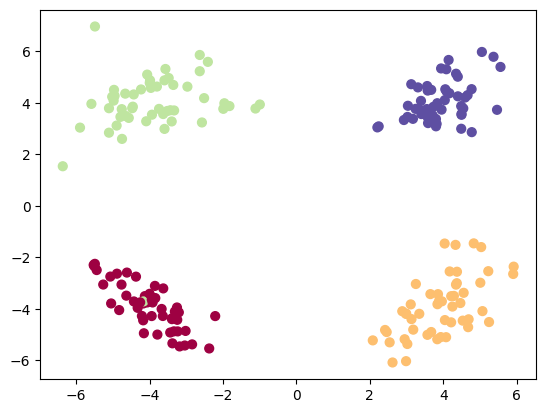

0-th iteration: 0.9138170575198151
Early stopping after 117 epochs.


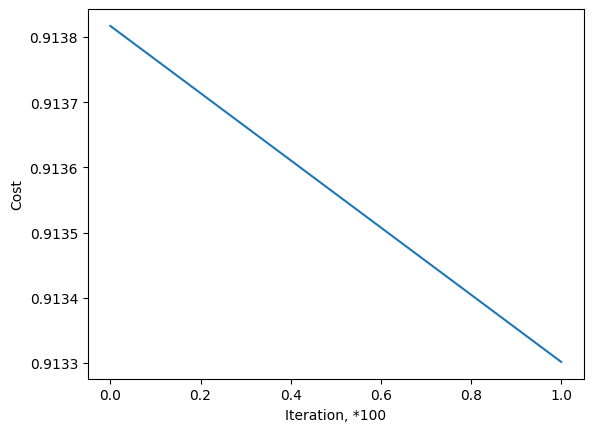

Accuracy: 
0.525
Report: 
              precision    recall  f1-score   support

           0       0.44      0.88      0.58         8
           1       0.00      0.00      0.00         9
           2       0.58      1.00      0.74        14
           3       0.00      0.00      0.00         9

    accuracy                           0.53        40
   macro avg       0.26      0.47      0.33        40
weighted avg       0.29      0.53      0.37        40

Confusion: 
   0  1   2  3
0  7  0   1  0
1  9  0   0  0
2  0  0  14  0
3  0  0   9  0


c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ректор\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

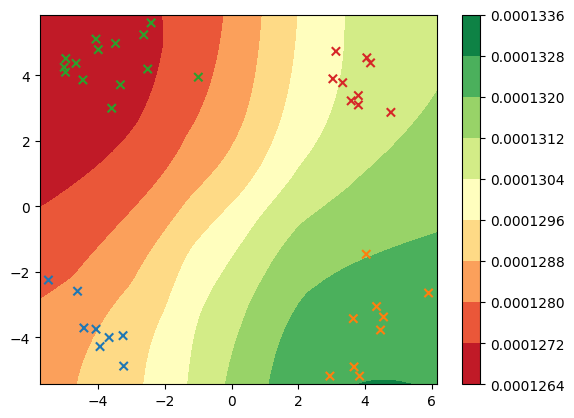

In [53]:
X, y = make_classification(n_samples = 200, n_classes = 4, n_features = 2, 
                            n_informative=2, n_redundant=0, random_state = 42,
                            flip_y=0.02, class_sep=4,  n_clusters_per_class=1)
plot_data(X, y)
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1, 1), test_size=0.2, random_state=42)

layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 4]
layer_activations_1 = ['tanh', 'sigmoid', 'relu', 'sigmoid', 'relu', 'softmax']
batch_size_1 = 32
keep_prob_1 = 0.9
patience_1 = 100

nn = NeuralNet(layer_dims_1, layer_activations_1, mini_batch_size=batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.001, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

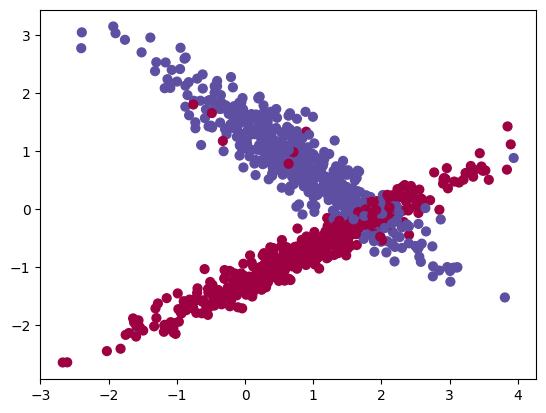

0-th iteration: 0.006477439791109304
1000-th iteration: 0.0021183772617819003
2000-th iteration: 0.001485817571890215
3000-th iteration: 0.0013899151982333002
Early stopping after 3343 epochs.


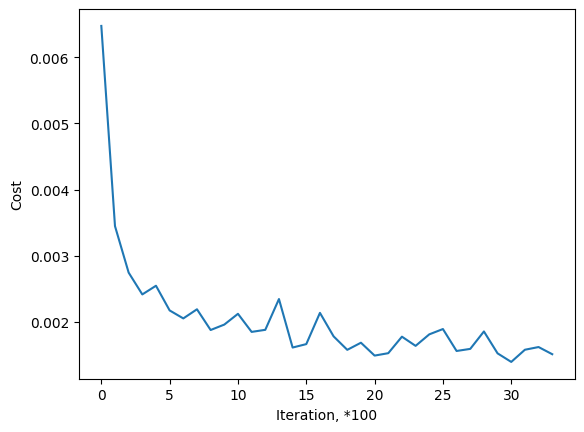

Accuracy: 
0.94
Report: 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       101
           1       0.93      0.95      0.94        99

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200

Confusion: 
    0   1
0  94   7
1   5  94


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [50]:
NUM_CLASSES = 2
X, y = make_classification(n_samples = 1000, n_classes = NUM_CLASSES, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8, n_clusters_per_class=1)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 1]
layer_activations_1 = ['relu', 'relu', 'relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_1 = 128
keep_prob_1 = 0.9
patience_1 = 3000

nn = NeuralNet(layer_dims_1, layer_activations_1, mini_batch_size=mini_batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.01, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_1[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 1

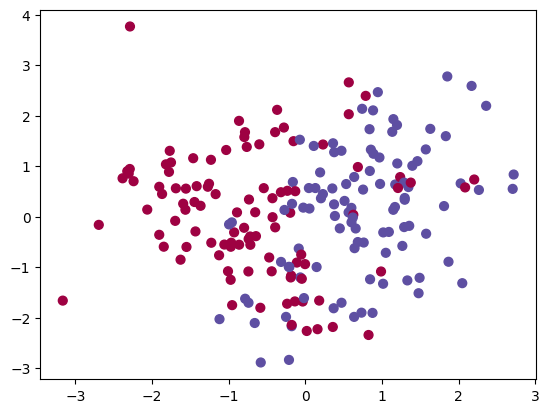

0-th iteration: 0.6932917965143522
1000-th iteration: 0.6924708881283175
2000-th iteration: 0.6910749674183514
3000-th iteration: 0.6846502141092426
4000-th iteration: 0.6581713331152426
5000-th iteration: 0.5875470896737025
6000-th iteration: 0.5072129664846389
7000-th iteration: 0.4653532360447594
8000-th iteration: 0.4492468646990282
9000-th iteration: 0.44322320850298047
10000-th iteration: 0.44087658158848275
11000-th iteration: 0.43988917672382755
12000-th iteration: 0.43941258911445974
13000-th iteration: 0.4391302463265994
14000-th iteration: 0.4389223931773299
15000-th iteration: 0.43874312732359955
16000-th iteration: 0.43857445191914907
17000-th iteration: 0.4384089278207441
18000-th iteration: 0.4382430795531844
19000-th iteration: 0.4380748748151141
20000-th iteration: 0.4379027549004163
21000-th iteration: 0.43772525874051804
22000-th iteration: 0.4375408768335589
23000-th iteration: 0.4373479975702168
24000-th iteration: 0.4371448950094845
25000-th iteration: 0.436929740

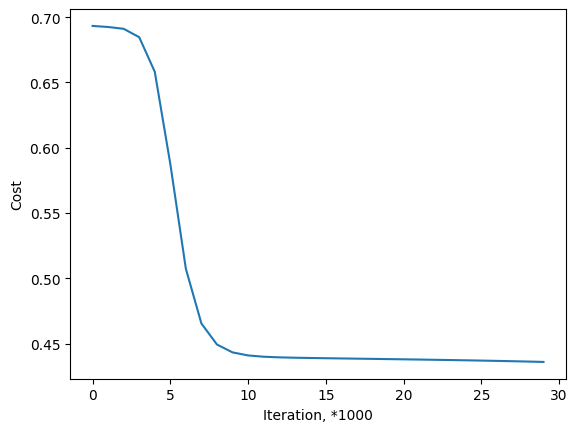

Accuracy: 
0.775
Report: 
              precision    recall  f1-score   support

           0       0.84      0.73      0.78        22
           1       0.71      0.83      0.77        18

    accuracy                           0.78        40
   macro avg       0.78      0.78      0.77        40
weighted avg       0.78      0.78      0.78        40

Confusion: 
    0   1
0  16   6
1   3  15


C:\Users\Ректор\AppData\Local\Temp\ipykernel_16424\624010783.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


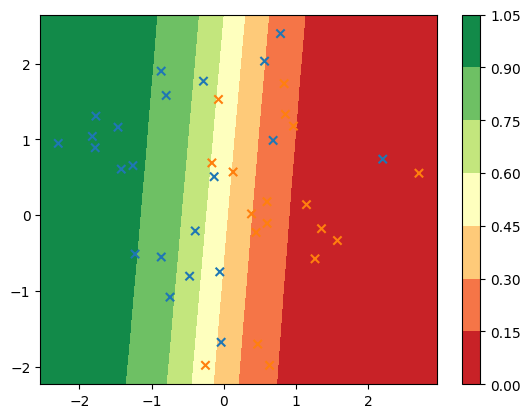

In [7]:
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)
plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet()
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Симульовані дані 2

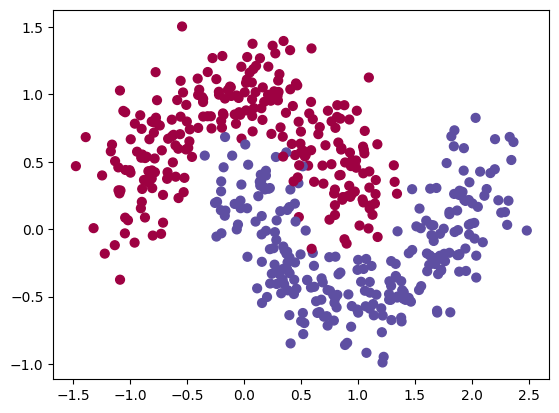

0-th iteration: 0.6930988941205961
1000-th iteration: 0.2818975420685595
2000-th iteration: 0.28108732461407543
3000-th iteration: 0.2806900281577706
4000-th iteration: 0.2804414672691518
5000-th iteration: 0.28026364990212926
6000-th iteration: 0.2801241260519352
7000-th iteration: 0.28000411232665295
8000-th iteration: 0.27988458901488444
9000-th iteration: 0.2797175388707468
10000-th iteration: 0.27909649264454467
11000-th iteration: 0.26681046652666757
12000-th iteration: 0.24743653594906023
13000-th iteration: 0.24039194829288377
14000-th iteration: 0.23721884110286795
15000-th iteration: 0.23539826126644858
16000-th iteration: 0.23400119041511147
17000-th iteration: 0.16059012837738393
18000-th iteration: 0.10192721625774766
19000-th iteration: 0.08261352183383315
20000-th iteration: 0.07134201024563337
21000-th iteration: 0.06362970023452447
22000-th iteration: 0.058299808913438
23000-th iteration: 0.05454334566472662
24000-th iteration: 0.05179462879261513
25000-th iteration: 0

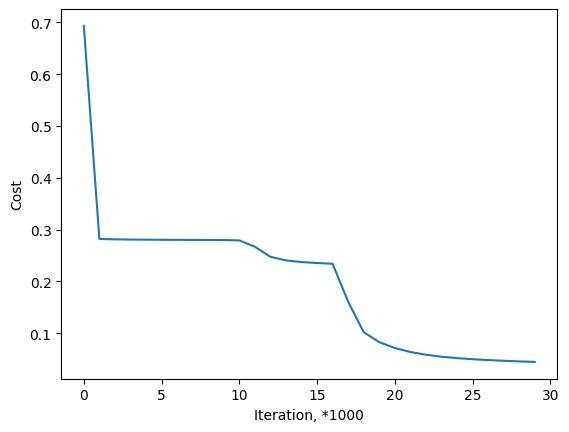

Accuracy: 
0.98
Report: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        43
           1       1.00      0.96      0.98        57

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100

Confusion: 
    0   1
0  43   0
1   2  55


C:\Users\Ректор\AppData\Local\Temp\ipykernel_16424\624010783.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


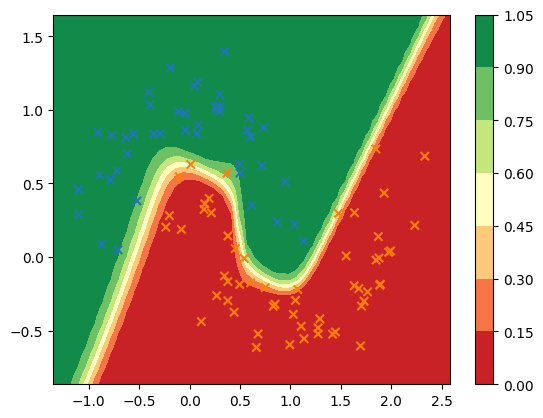

In [8]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

nn = NeuralNet(learning_rate = 0.5)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

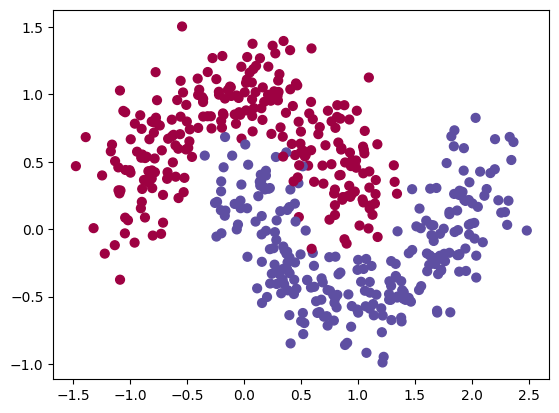

0-th iteration: 0.023185682344905166
1000-th iteration: 0.011004187889846685


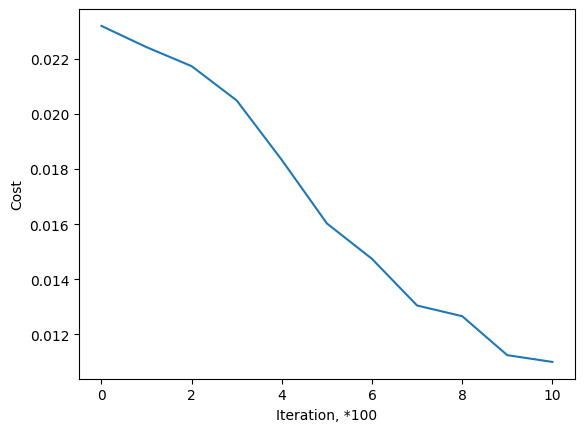

Accuracy: 
0.85
Report: 
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        43
           1       0.94      0.79      0.86        57

    accuracy                           0.85       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.85      0.85       100

Confusion: 
    0   1
0  40   3
1  12  45


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12104\333026692.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


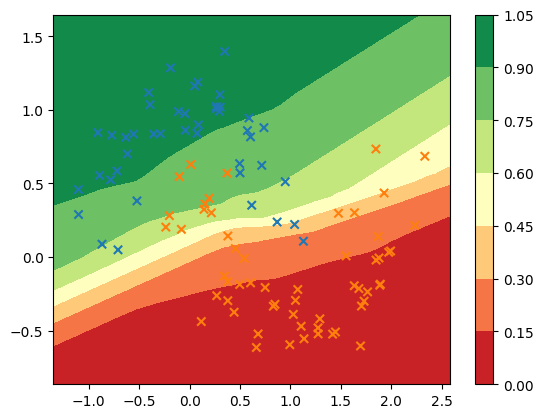

In [16]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_dims_2 = [X.shape[1], 10, 10, 5, 1]
layer_activations_2 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_2 = 32
keep_prob_2 = 0.9
patience_2 = 2000

nn = NeuralNet(layer_dims_2, layer_activations_2, mini_batch_size=mini_batch_size_2, keep_prob=keep_prob_2, patience=patience_2, learning_rate = 0.001, num_epochs=1000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_2[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

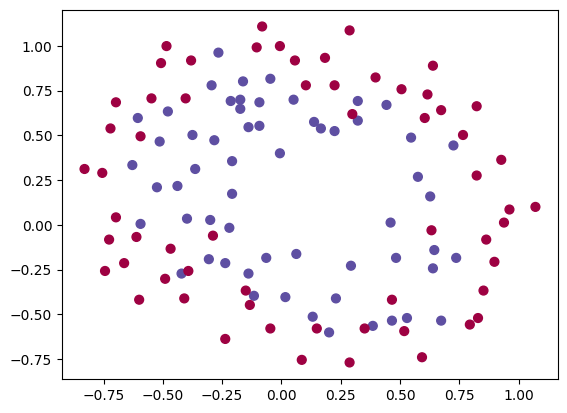

In [18]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y.reshape(-1,1), test_size=0.2, random_state=42)

0-th iteration: 0.6932489411003449
1000-th iteration: 0.683896798731569
2000-th iteration: 0.6785959143703956
3000-th iteration: 0.5398613388162804
4000-th iteration: 0.390144836583928
5000-th iteration: 0.3551990859615269
6000-th iteration: 0.3283787300030659
7000-th iteration: 0.3159986693470118
8000-th iteration: 0.3073962484750829
9000-th iteration: 0.29985203157893736


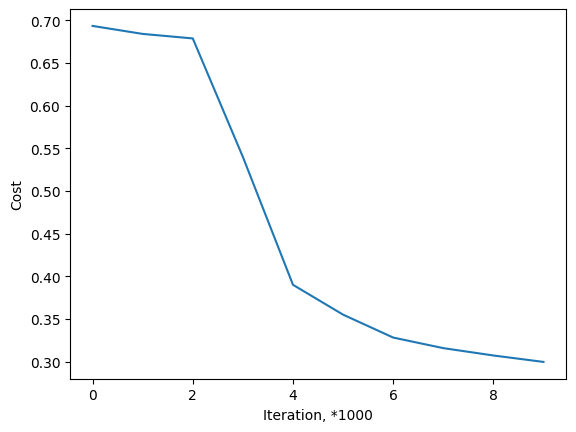

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.75      0.75      0.75        12

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24

Confusion: 
   0  1
0  9  3
1  3  9


C:\Users\Ректор\AppData\Local\Temp\ipykernel_16424\624010783.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


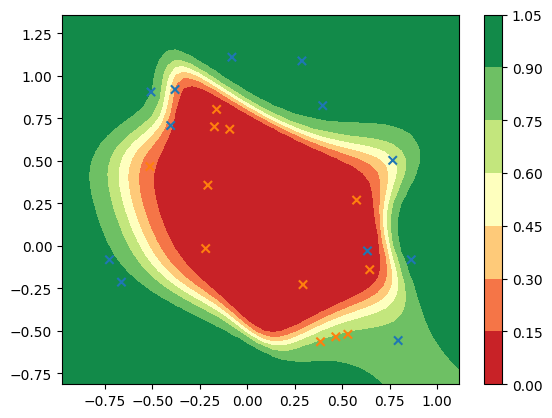

In [10]:
nn = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 10000)
nn.fit(X_train, y_train)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [11]:
print(nn.parameters)

{'W1': array([[-8.36917215, -2.56026641],
       [-0.72255625,  0.14046741],
       [ 0.18305144,  0.29626355],
       [-0.42195139,  0.23278914],
       [-1.01096138,  0.3876082 ],
       [ 0.21453843,  0.3128495 ],
       [ 0.40169264,  0.4052115 ],
       [ 0.99913078,  0.89569834],
       [-0.49495029,  0.23552192],
       [ 0.33218655,  0.3800388 ],
       [-0.38295654,  0.24940215],
       [-0.12040362,  0.26490939],
       [-0.98300796,  0.20093684],
       [-4.28291462, -4.22295019],
       [ 0.30096928,  4.31949062],
       [-2.66855324, -1.18078056],
       [ 3.97638367, -3.3752236 ],
       [-0.94879586,  0.28385434],
       [ 0.46753349, -3.99363547],
       [-0.67351256,  0.15922767]]), 'b1': array([[-3.70480689],
       [-0.49799952],
       [ 0.0343494 ],
       [-0.17468268],
       [-1.55689788],
       [ 0.04905742],
       [ 0.14000009],
       [ 0.38991443],
       [-0.23771317],
       [ 0.11755419],
       [-0.15187067],
       [-0.03569235],
       [-1.31615219],

0-th iteration: 0.02176795950228564
1000-th iteration: 0.017525423404431834
Early stopping after 1067 epochs.


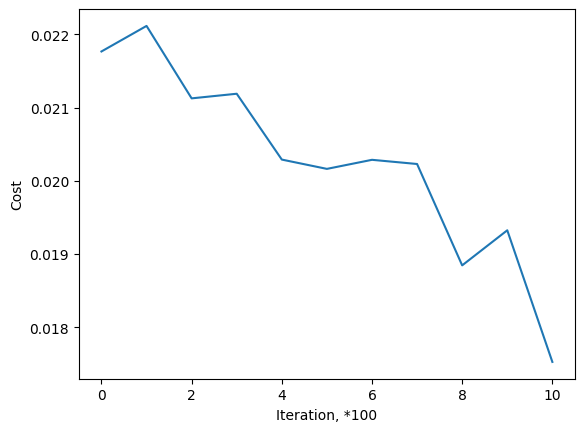

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.71      0.83      0.77        12

    accuracy                           0.75        24
   macro avg       0.76      0.75      0.75        24
weighted avg       0.76      0.75      0.75        24

Confusion: 
   0   1
0  8   4
1  2  10


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12104\333026692.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


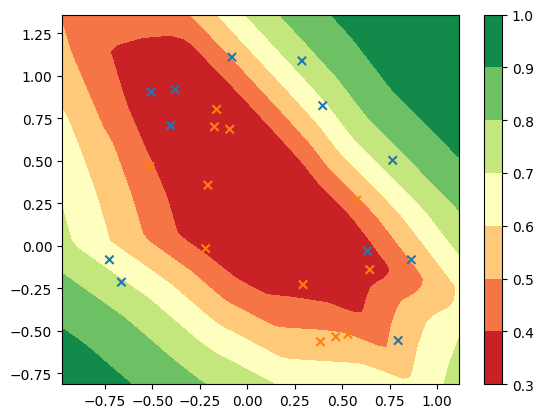

In [19]:
layer_dims_3 = [X.shape[1], 10, 10, 5, 1]
layer_activations_3 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_3 = 32
keep_prob_3 = 0.9
patience_3 = 500

nn = NeuralNet(layer_dims_3, layer_activations_3, mini_batch_size=mini_batch_size_3, keep_prob=keep_prob_3, patience=patience_3, normalize = True, learning_rate = 0.01, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_3[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

Accuracy: 
0.75
Report: 
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.75      0.75      0.75        12

    accuracy                           0.75        24
   macro avg       0.75      0.75      0.75        24
weighted avg       0.75      0.75      0.75        24

Confusion: 
   0  1
0  9  3
1  3  9


C:\Users\Ректор\AppData\Local\Temp\ipykernel_12104\624010783.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


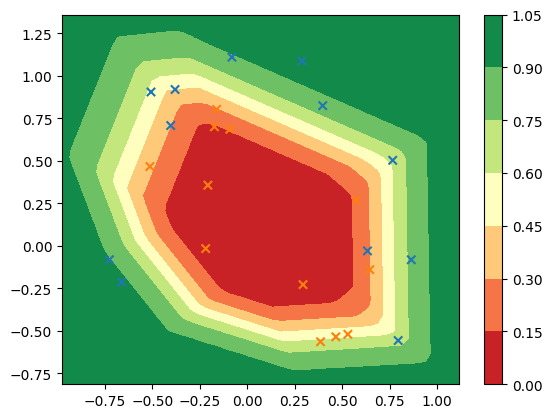

In [22]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(clf, X_test, y_test)
plt.show()

In [23]:
clf.n_iter_

1731